In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from umap import UMAP
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
from llama_index.llms.openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from hdbscan import HDBSCAN
import regex as re 
import subprocess
import importlib
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document

os.chdir("/work/submit/mcgreivy/beauty-in-stats/graph_rag")

## Chunked Corpus Embeddings

In [2]:
def clean_latex(text):
    environments = [
        r'\\begin\{figure\*?\}.*?\\end\{figure\*?\}',
        r'\\begin\{aligned\*?\}.*?\\end\{aligned\*?\}',
        r'\\begin\{alignat\*?\}.*?\\end\{alignat\*?\}',
        r'\\begin\{linenomath\*?\}.*?\\end\{linenomath\*?\}',
        r'\\begin\{subequations\*?\}.*?\\end\{subequations\*?\}',
        r'\\begin\{landscape\*?\}.*?\\end\{landscape\*?\}',
        
        r'\\begin\{wrapfigure\*?\}.*?\\end\{wrapfigure\*?\}',
        r'\\begin\{table\*?\}.*?\\end\{table\*?\}',
        r'\\begin\{sidewaystable\*?\}.*?\\end\{sidewaystable\*?\}',
        r'\\begin\{equation\*?\}.*?\\end\{equation\*?\}',
        r'\\begin\{displaymath\*?\}.*?\\end\{displaymath\*?\}',
        r'\\begin\{align\*?\}.*?\\end\{align\*?\}',
        r'\\begin\{eqnarray\*?\}.*?\\end\{eqnarray\*?\}',
        r'\\begin\{multline\*?\}.*?\\end\{multline\*?\}',
        r'\\begin\{gather\*?\}.*?\\end\{gather\*?\}',
        r'\\begin\{tabular\*?\}.*?\\end\{tabular\*?\}',
        r'\\begin\{thebibliography\}.*?\\end\{thebibliography\}',
        r'\\label\{.*?\}',
        r'\~?\\cite\{.*?\}',
        r'\~?\\ref\{.*?\}',
        r'.*\\begin\{document\}',
    ]
    
    for pattern in environments:
        text = re.sub(pattern, ' ', text, flags=re.DOTALL)

    marker = "\\section{Introduction}"
    position = text.find(marker)
    if position > 0:
        text = text[position:]

    text = re.sub(r'\%.*\n', "", text)
    text = re.sub(r"\n\s*", "\n", text)
    text = re.sub(r'(?<!\\)\$', ' ', text)
    text = re.sub(r'(?<!\\)\\(?!\\)', ' ', text)
    text = re.sub(r'(?<!\\)\{', ' ', text)
    text = re.sub(r'(?<!\\)\}', ' ', text)
    text = re.sub(r'([^\S\n])+', ' ', text)
    return text

def clean_pdg(text):
    index = text.find("\nReferences\n")
    text = text[:index]
    pattern = r'\[\s*\d+(?:\s*(?:-|–|—)\s*\d+)?(?:\s*,\s*\d+(?:\s*(?:-|–|—)\s*\d+)?)*\s*\]'
    text = re.sub(pattern, '', text)
    return text


text = """"""

pdg_dir = "/work/submit/mcgreivy/beauty-in-stats/graph_rag/data/PDG/"
for file in os.listdir(pdg_dir):
    if file[-4:] in ".pdf":
        input_file = f"{file[:-4]}.pdf"
        output_file = f"{file[:-4]}.tex"
        command = f"/work/submit/mcgreivy/miniconda3/envs/BeautyInStats/bin/pdftotext -layout -x 0 -y 72 -W 612 -H 648 {pdg_dir + input_file} {pdg_dir + output_file}"
        subprocess.run(command.split(), text=True)

        with open(pdg_dir + output_file, "r") as f:
            text += clean_pdg(f.read()) + "\n\n\n\n\n\n"

source_directory = "/work/submit/mcgreivy/beauty-in-stats/graph_rag/data/arXiv"
for root, dirs, files in os.walk(source_directory):
    for file in files:
        if file.endswith(".tex"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                text += clean_latex(f.read()) + "\n\n\n\n\n\n"

source_directory = "/work/submit/mcgreivy/beauty-in-stats/src/scraper/data/cleaned_tex"
for root, dirs, files in os.walk(source_directory):
    for file in files:
        if file.endswith(".tex"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                text += clean_latex(f.read()) + "\n\n\n\n\n\n"


In [3]:
# text_splitter = SentenceSplitter(
#     chunk_size=350,
#     chunk_overlap=50,
#     separator="\n",
#     paragraph_separator="\n\n",
#     secondary_chunking_regex="(?<=[.!?])\s+",
# )

# document = Document(text=text)
# chunks = np.array([node.text for node in text_splitter.get_nodes_from_documents([document])])
# print(len(chunks))

# from sentence_transformers import SentenceTransformer
# embedding_model = SentenceTransformer("BAAI/bge-m3")
# embeddings = embedding_model.encode(chunks, show_progress_bar=True)

In [4]:
embeddings_dir = '/work/submit/mcgreivy/beauty-in-stats/graph_rag/data/saved_embeddings/entire_corpus_embeddings.npy'
chunks_dir = '/work/submit/mcgreivy/beauty-in-stats/graph_rag/data/saved_embeddings/entire_corpus_chunks.npy'

## SAVE:
# np.save(embeddings_dir, embeddings)
# np.save(chunks_dir, chunks)
## LOAD:
embeddings = np.load(embeddings_dir)
chunks = np.load(chunks_dir)

In [5]:
import SubjectCluster
importlib.reload(SubjectCluster)

<module 'SubjectCluster' from '/work/submit/mcgreivy/beauty-in-stats/graph_rag/SubjectCluster.py'>

In [6]:
cluster = SubjectCluster.SubjectCluster(chunks, embeddings, "LHCb group at the Large Hadron Collider, Particle Physics Papers", reduced_dim = 16, optimal_clusters = 4, min_cluster_size = 25)

In [8]:
cluster.create_all_subclusters()

In [33]:
cluster.visualize_hierarchy()

● LHCb group at the Large Hadron Collider, Particle Physics Papers
  ├─ Data Processing and Analysis Techniques (115 chunks)
    ├─ Data Processing Techniques (89 chunks)
    └─ Analysis Methodologies (26 chunks)
  ├─ Bayesian Statistical Methods in Particle Physics (830 chunks)
    ├─ Machine Learning Techniques for Anomaly Detection (317 chunks)
      ├─ Convolutional Neural Networks for Image Analysis (48 chunks)
      ├─ Bayesian Machine Learning for Regression and Classification (55 chunks)
      └─ Anomaly Detection Techniques in Particle Physics (116 chunks)
    └─ Bayesian Inference and Statistical Methods (513 chunks)
      ├─ Gaussian Distributions and Random Variables (54 chunks)
      ├─ Likelihood Estimation and Measurement Uncertainties (58 chunks)
      ├─ Bayesian Inference and Prior Beliefs (69 chunks)
      └─ Confidence Intervals and Hypothesis Testing (111 chunks)
  └─ Decay Processes and Signal Analysis in LHCb Experiments (17588 chunks)
    ├─ ACR Detector Electro

In [28]:
print(cluster.subclusters[0].subclusters)

{0: SubjectCluster('LHCb group at the Large Hadron Collider, Particle Physics Papers --> Data Processing and Analysis Techniques --> Data Processing Techniques', -1 clusters, 0/89 chunks clustered, 0 subclusters), 1: None}


## Cluster Embeddings

In [85]:
stopwords = [
    # LaTeX formatting
    'begin', 'end', 'align', 'equation', 'itemize', 'ref', 'cite', 'label', 
    'includegraphics', 'width', 'nonumber', 'textrm', 'mathrm', 'textbf',
    'mathcal', 'overline', 'cdots', 'bf', 'frac', 'quad', 'pm',
    
    # Common physics/math notation
    'sigma', 'delta', 'lambda', 'alpha', 'beta', 'theta', 'mu', 'nu', 'pi',
    'partial', 'vec', 'hat', 'tilde', 'bar',
    
    # Common physics terms that are too generic
    'particle', 'physics', 'energy', 'mass', 'time', 'event', 'events',
    'function', 'value', 'values', 'approach', 'case', 'given', 'number', 'proton', 'data', 'eq', 'probability', 'statistics', 
    
    # English stopwords
    'fig', 'figure', 'equation', 'example', 'left', 'right', 'sincere', 'inc', 'seems', 'her', 'already', 'amount', 'etc', 'part', 'ourselves', 'find', 'nor', 'anyhow', 'last', 'always', 'sixty', 'toward', 'two', 'describe', 'please', 'see', 'about', 'herein', 'has', 'was', 'three', 'until', 'which', 'to', 'your', 'why', 'on', 'thick', 'perhaps', 'same', 'often', 'move', 'whose', 'whether', 'side', 'thereupon', 'much', 'fire', 'twelve', 'else', 'show', 'elsewhere', 'whole', 'because', 'serious', 'call', 'fifteen', 'via', 'give', 'interest', 'go', 'ever', 'everywhere', 'all', 'seem', 'among', 'indeed', 'are', 'i', 'whereby', 'moreover', 'eight', 'back', 'us', 'will', 'themselves', 'tchen', 'thru', 'namely', 'after', 'formerly', 'very', 'they', 'at', 'up', 'whereupon', 'herself', 'beside', 'hereby', 'rather', 'third', 'now', 'bottom', 'fifty', 'nothing', 'anyone', 'hers', 'there', 'sometimes', 'behind', 'by', 'though', 'hereupon', 'is', 'eg', 'who', 'former', 're', 'cannot', 'along', 'hasnt', 'whereas', 'again', 'thereafter', 'front', 'nevertheless', 'off', 'both', 'our', 'therefore', 'however', 'therein', 'whoever', 'con', 'everything', 'he', 'me', 'besides', 'five', 'my', 'either', 'have', 'himself', 'too', 'several', 'itself', 'could', 'it', 'mill', 'not', 'had', 'whom', 'bill', 'per', 'whenever', 'over', 'amoungst', 'these', 'co', 'than', 'yourselves', 'four', 'beyond', 'nine', 'out', 'the', 'whereafter', 'thin', 'mostly', 'couldnt', 'a', 'every', 'twenty', 'wherever', 'anything', 'were', 'also', 'one', 'for', 'within', 'whence', 'whither', 'keep', 'another', 'how', 'sometime', 'un', 'throughout', 'few', 'nowhere', 'take', 'an', 'when', 'him', 'none', 'except', 'towards', 'during', 'thence', 'thereby', 'further', 'latter', 'what', 'other', 'can', 'made', 'be', 'into', 'hundred', 'ten', 'meanwhile', 'thus', 'hereafter', 'ours', 'first', 'noone', 'its', 'yours', 'each', 'system', 'between', 'hence', 'full', 'would', 'others', 'once', 'eleven', 'seeming', 'afterwards', 'from', 'although', 'around', 'somehow', 'no', 'but', 'many', 'been', 'get', 'down', 'whatever', 'such', 'here', 'together', 'without', 'even', 'below', 'own', 'or', 'forty', 'fill', 'someone', 'only', 'any', 'this', 'name', 'through', 'found', 'put', 'yet', 'mine', 'should', 'amongst', 'cry', 'must', 'being', 'more', 'seemed', 'next', 'am', 'still', 'as', 'latterly', 'before', 'anywhere', 'everyone', 'somewhere', 'them', 'she', 'cant', 'well', 'of', 'otherwise', 'may', 'in', 'across', 'with', 'nobody', 'might', 'becomes', 'empty', 'anyway', 'beforehand', 'do', 'something', 'most', 'his', 'done', 'their', 'least', 'became', 'less', 'myself', 'enough', 'detail', 'ltd', 'wherein', 'almost', 'you', 'become', 'yourself', 'onto', 'if', 'becoming', 'some', 'we', 'so', 'due', 'top', 'six', 'upon', 'while', 'above', 'ie', 'and', 'that', 'those', 'neither', 'de', 'never', 'since', 'alone', 'where', 'against', 'under'
]

def cluster_topics(chunks, embeddings, context, ignore_keywords=[], reduced_dim=16, min_cluster_size=12, keyword_cutoff=0.25):
    fig, axs = plt.subplots(3, 1, figsize=(12, 24))

    umap_model = UMAP(
        n_components=reduced_dim, min_dist=0.0, metric='cosine'
    )
    reduced_embeddings = umap_model.fit_transform(embeddings)

    num_clusters = []
    proportion_unclustered = []

    min_clusters = 2
    max_clusters = max(2*min_cluster_size, 40)
    cluster_sizes = list(range(min_clusters, max_clusters, 1 + (max_clusters - min_clusters)//100))
    for cluster_size in cluster_sizes:

        # We fit the model and extract the clusters
        hdbscan_model = HDBSCAN(
            min_cluster_size=cluster_size, metric='euclidean', cluster_selection_method='eom'
        ).fit(reduced_embeddings)
        clusters = hdbscan_model.labels_

        # How many clusters did we generate?
        num_clusters.append(len(set(clusters)))

        proportion_unclustered.append(np.sum(clusters == -1) / len(clusters))

    axs[0].plot(cluster_sizes, num_clusters)
    axs[0].set_xlabel("Minimum cluster size")
    axs[0].set_ylabel("Number of clusters found")
    axs[0].set_ylim(1, 10*max(num_clusters))
    axs[0].set_yscale("log")

    axs[1].plot(cluster_sizes, proportion_unclustered)
    axs[1].set_xlabel("Minimum cluster size")
    axs[1].set_ylabel("Proportion of Unclustered Chunks")
    axs[1].set_ylim(0, 1)

    # We fit the model and extract the clusters
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom'
    ).fit(reduced_embeddings)
    clusters = hdbscan_model.labels_

    vectorizer = TfidfVectorizer(
        stop_words=stopwords + ignore_keywords,
        max_df=0.9,          
        min_df=2,            
        ngram_range=(1, 2)
    )
    vectorizer.fit(chunks)

    def get_top_keywords(cluster_chunks, n_keywords=50):
        if len(cluster_chunks) == 0:
            return []

        tfidf_matrix = vectorizer.transform(cluster_chunks)
        
        feature_names = vectorizer.get_feature_names_out()
        
        tfidf_sums = np.sum(tfidf_matrix.toarray(), axis=0)

        top_indices = tfidf_sums.argsort()[-n_keywords:][::-1]
        top_tfidf = tfidf_sums.max()
        top_keywords = [(feature_names[i], tfidf_sums[i]) for i in top_indices if tfidf_sums[i] > keyword_cutoff * top_tfidf]
        
        return top_keywords

    # Example usage:
    top_keywords = []
    for cluster in range(0, np.max(clusters + 1)):
        cluster_chunks = chunks[clusters == cluster]
        top_keywords.append(get_top_keywords(cluster_chunks))

    unclustered_keywords = get_top_keywords(chunks[clusters == -1])

    llm = OpenAI(temperature=0, model="gpt-4o-mini")

    keyword_str = " \n".join([
        f"Cluster {cluster} keywords: {{{', '.join([f'{keyword}: {importance:.2f}' for keyword, importance in top_keywords[cluster]])}}}" 
        for cluster in range(len(top_keywords))
    ])

    prompt = f"""
Using a corpus of documents, I have chunked the text and used a sentence embedding model to generate paragraph embeddings for each chunk. Using UMAP + HDBSCAN as a clustering algorithm, the chunks have been clustered. Comparing chunks within a cluster to chunks outside of it, the TF-IDF algorithm has identified the primary keywords within each cluster.

Below I have provided the primary keywords along with their importance scores for each cluster. I have also provided the top keywords and importances across all the chunks which were not clustered at all. By comparing keywords within each cluster and contrasting them across different clusters, you should construct a few words label that summarizes the unique content of each cluster. 

The broader context of these documents is "{context}".

Give your answer as a python dictionary. Do not respond with anything else, including with ```python ... ```

{{0: "Cluster 0 Name", 1: "Cluster 1 Name", ...}}

Unclustered Keywords:

{", ".join([f"{keyword} : {importance:.2f}" for keyword, importance in unclustered_keywords])}

Clustered Keywords:

{keyword_str}
"""
    
    answer = llm.complete(prompt, temperature=0.0)
    cluster_labels = eval(answer.text)

    # We reduce the input embeddings from 384 dimensions to 2 dimensions
    umap_model = UMAP(
        n_components=2, min_dist=0.0, metric='cosine'
    )
    scatter_embeddings = umap_model.fit_transform(embeddings)

    unclustered_embeddings = scatter_embeddings[clusters == -1]
    clustered_embeddings = scatter_embeddings[clusters > -1]
    clustered_clusters = clusters[clusters > -1]

    # Create a colormap to match the scatter plot
    cmap = matplotlib.colormaps["cool"]
    norm = plt.Normalize(min(clusters), max(clusters))

    # Plot the scatter plot
    scatter = axs[2].scatter(unclustered_embeddings[:,0], unclustered_embeddings[:,1], color="grey", alpha=0.7)
    scatter = axs[2].scatter(clustered_embeddings[:,0], clustered_embeddings[:,1], c=clustered_clusters, cmap=cmap, alpha=0.7)

    for cluster in range(0, max(clusters) + 1):
        embs = scatter_embeddings[clusters == cluster]
        mean_x, mean_y = embs[:,0].mean(), embs[:,1].mean()

        cluster_color = cmap(norm(cluster))
        axs[2].scatter(mean_x, mean_y, color=cluster_color, alpha=0.5, s=4000)
        axs[2].text(mean_x, mean_y, cluster_labels[cluster], 
        color=cluster_color, alpha=1.0, fontsize=14,     
        path_effects=[
            path_effects.withStroke(linewidth=3, foreground='white')
        ])

    # Add legend and title
    axs[2].set_title('UMAP Projection of Clusters with Descriptions', fontsize=14)
    axs[2].set_xlabel('UMAP Dimension 1')
    axs[2].set_ylabel('UMAP Dimension 2')

    # Remove ticks to make it cleaner
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    plt.show()

    return clusters, cluster_labels, [ignore_keywords + [top_keywords[cluster][i][0] for i in range(len(top_keywords[cluster]))] for cluster in range(len(top_keywords))]

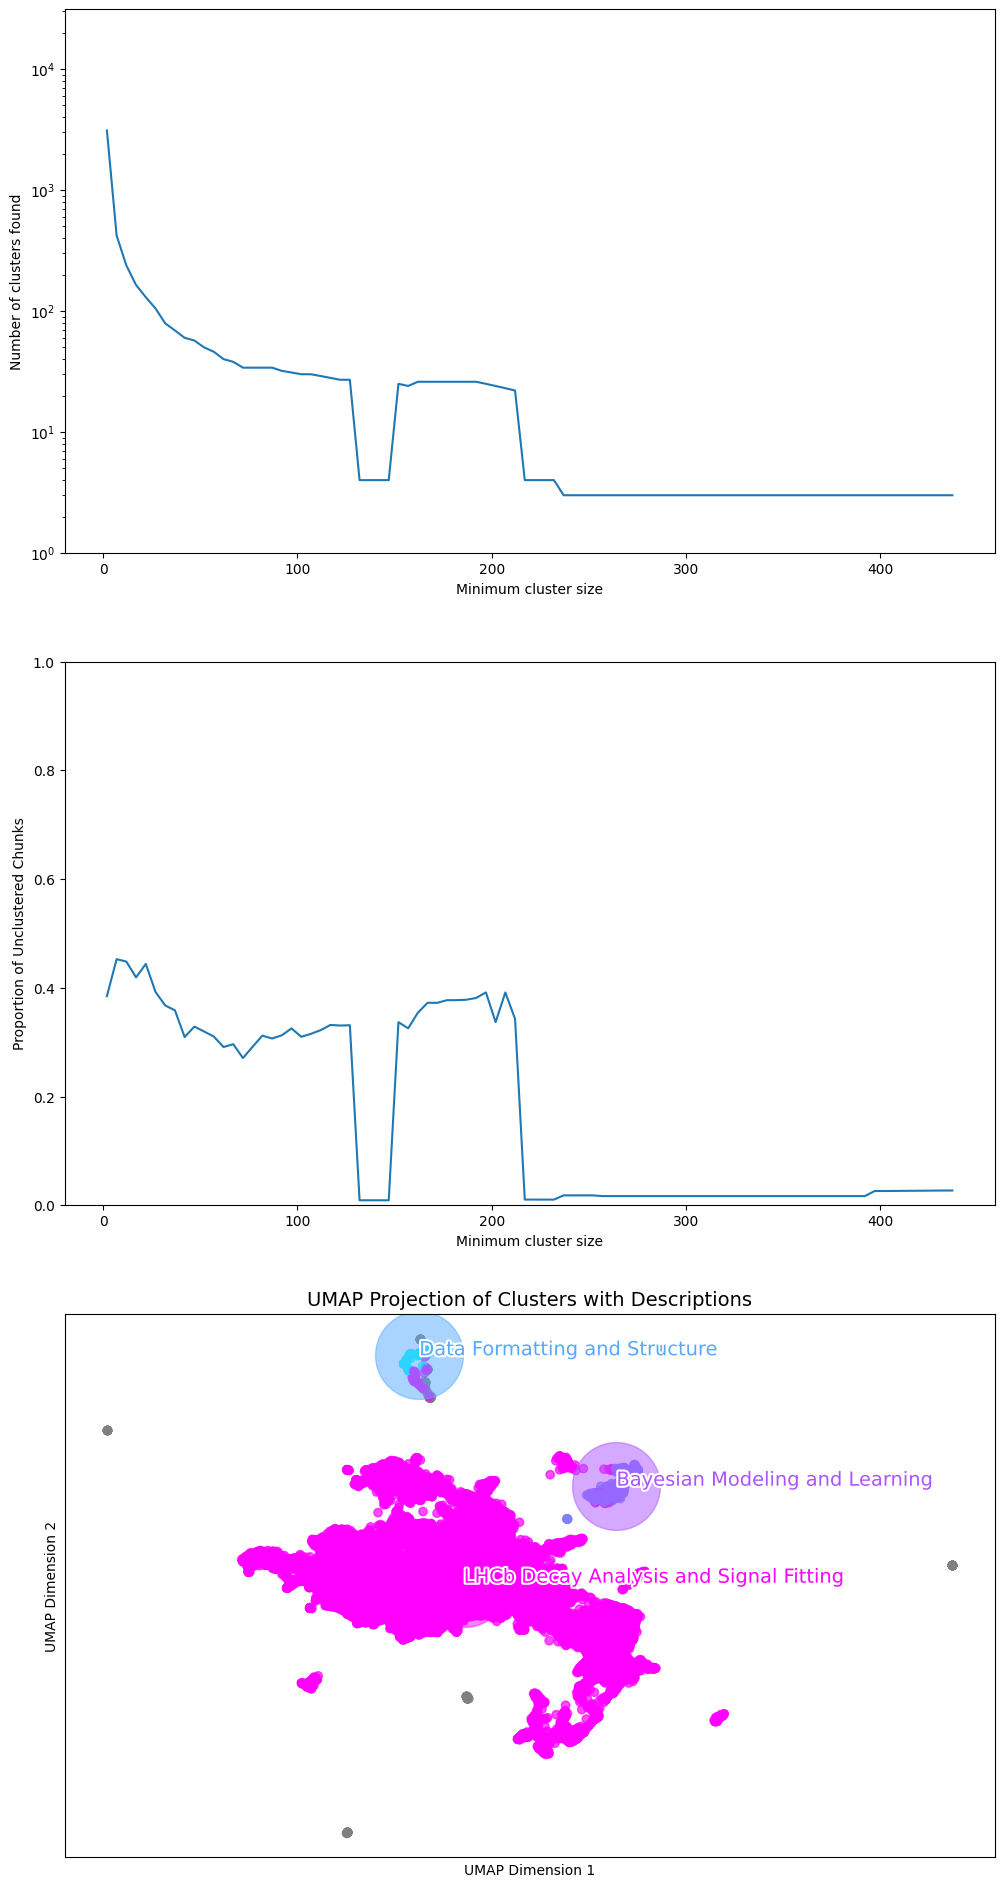

In [86]:
context = "LHCb Particle Physics Papers"
clusters, cluster_labels, cluster_keywords = cluster_topics(chunks, embeddings, context=context, ignore_keywords=[], reduced_dim=16, min_cluster_size=220, keyword_cutoff=0.25)

In [90]:
print(cluster_labels)

i = 0
cluster_label = f"{context} --> {cluster_labels[i]}"
cluster_chunks = chunks[clusters == i]
cluster_embeddings = embeddings[clusters == i]
cluster_ignore_keywords = cluster_keywords[i]

print(cluster_label)

{0: 'Data Formatting and Structure', 1: 'Bayesian Modeling and Learning', 2: 'LHCb Decay Analysis and Signal Fitting'}
LHCb Particle Physics Papers --> Data Formatting and Structure


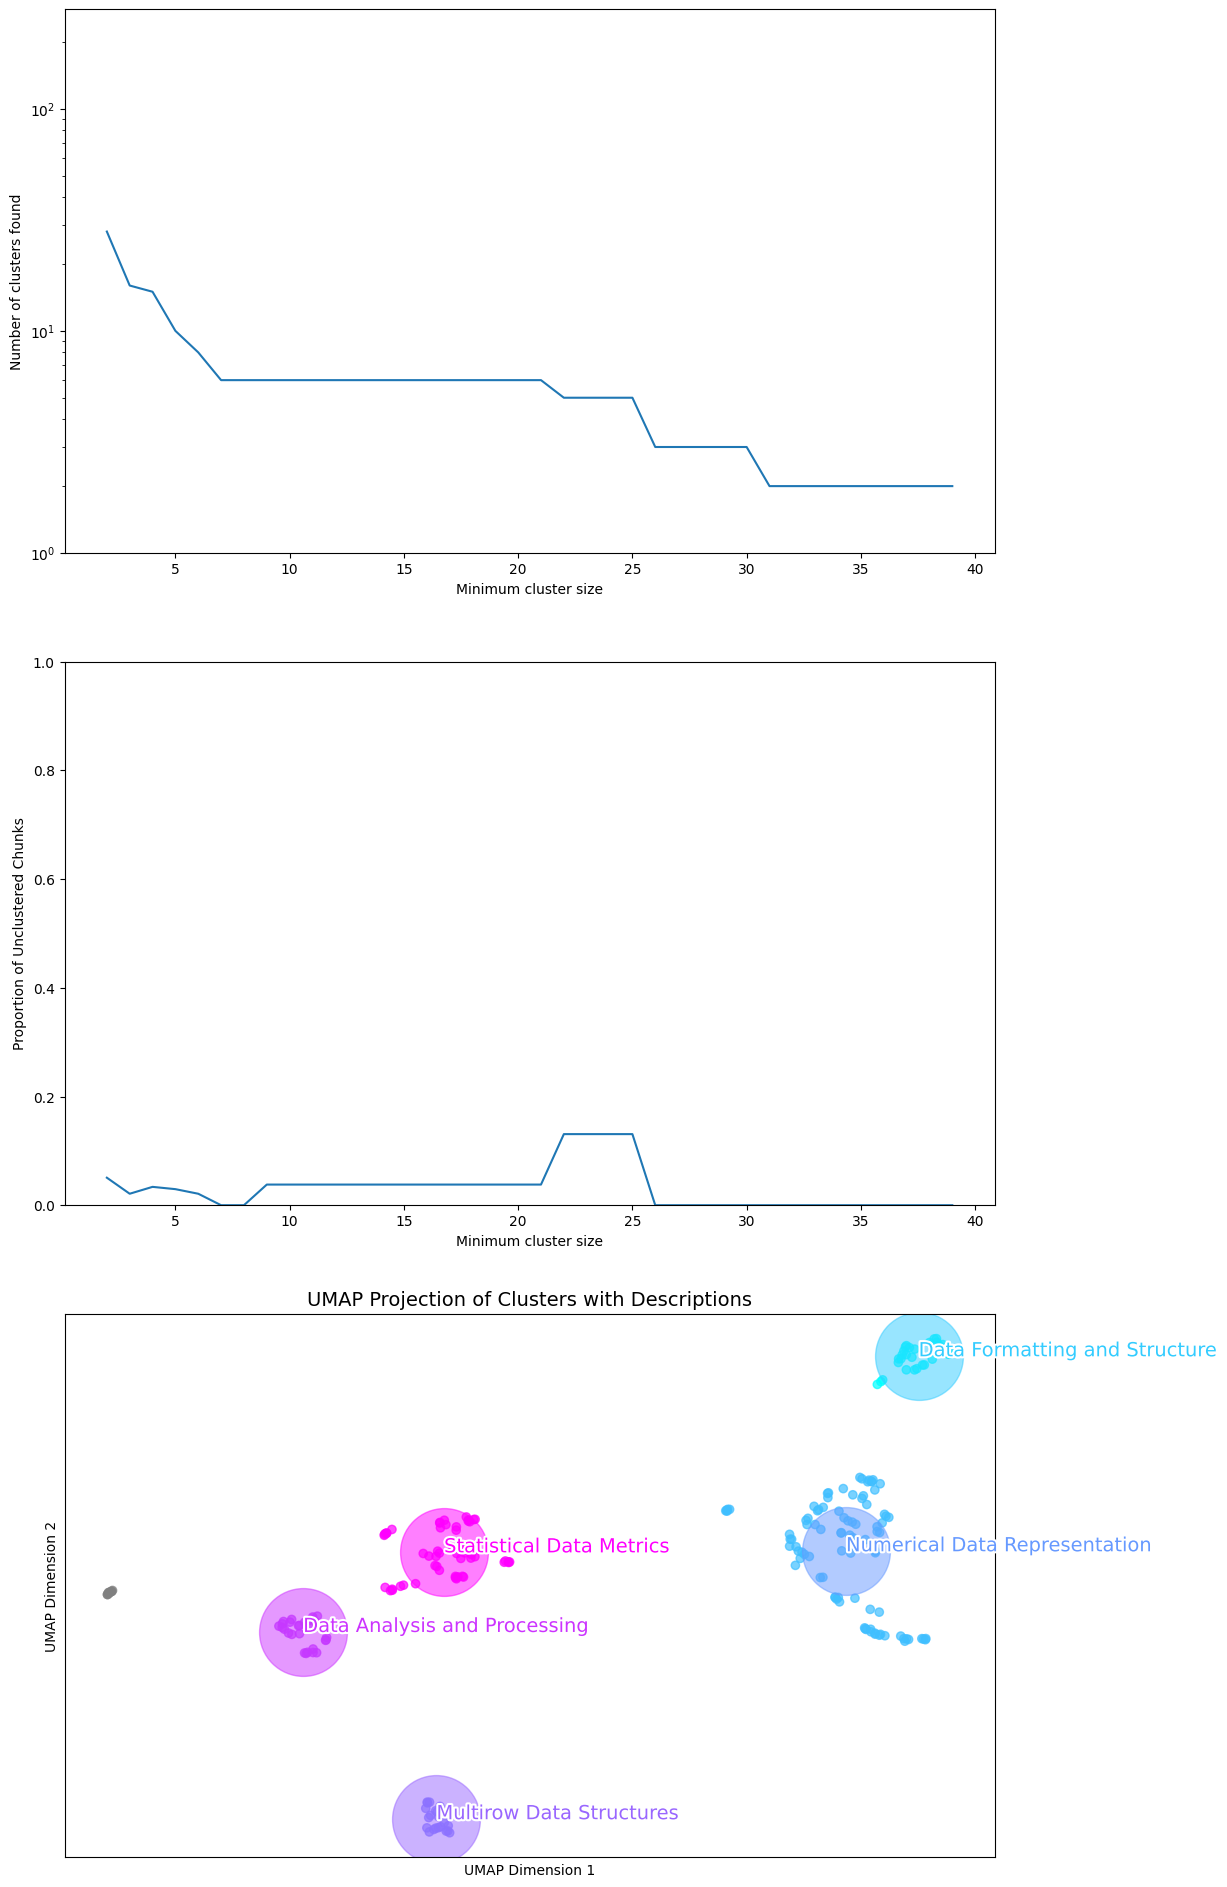

In [89]:
subclusters, subcluster_labels, subcluster_keywords = cluster_topics(cluster_chunks, cluster_embeddings, context=cluster_label, ignore_keywords=cluster_ignore_keywords, reduced_dim=16, min_cluster_size=20, keyword_cutoff=0.25)

In [106]:
print(subcluster_labels)

i = 4
subcluster_label = f"{cluster_label} --> {subcluster_labels[i]}"
subcluster_chunks = cluster_chunks[subclusters == i]
subcluster_embeddings = cluster_embeddings[subclusters == i]
subcluster_ignore_keywords = subcluster_keywords[i]

print(subcluster_label)

{0: 'Data Formatting and Structure', 1: 'Numerical Data Representation', 2: 'Multirow Data Structures', 3: 'Data Analysis and Processing', 4: 'Statistical Data Metrics'}
LHCb Particle Physics Papers --> Data Formatting and Structure --> Statistical Data Metrics


In [109]:
print(subcluster_chunks[2])

7-8
& 175.08 \pm 3.34 \pm 11.48& 156.34 \pm 2.18 \pm 9.76& 136.22 \pm 1.90 \pm 8.62& 107.01 \pm 1.87 \pm 8.15& 67.50 \pm 2.05 \pm 8.26\\ 
8-9
& 134.33 \pm 2.86 \pm 8.69& 119.99 \pm 1.86 \pm 7.49& 103.59 \pm 1.58 \pm 6.65& 79.26 \pm 1.57 \pm 6.62& 51.49 \pm 1.85 \pm 6.58\\ 
9-10
& 101.78 \pm 2.46 \pm 6.58& 89.18 \pm 1.54 \pm 5.63& 76.04 \pm 1.34 \pm 4.98& 59.62 \pm 1.33 \pm 5.06& 38.61 \pm 1.59 \pm 5.52\\
10-11


0.336101083032491
0.4509025270758123
0.455956678700361
0.5292418772563177
0.5584837545126354
0.5772563176895307
0.5422382671480145
0.572202166064982
0.47942238267148013
0.5509025270758122
0.5465703971119134
0.564259927797834
0.5750902527075812
0.49891696750902526
0.5671480144404332
0.5848375451263538
0.5617328519855596
0.5660649819494585
0.5909747292418772
0.6007220216606498
0.5545126353790614
0.5664259927797833
0.5620938628158845
0.6462093862815884
0.5072202166064982
0.5299638989169675
0.6353790613718412
0.6075812274368231
0.4787003610108303
0.36028880866425994
0.42057761732851984
0.5003610108303249
0.12274368231046931
0.1256317689530686
0.4126353790613718
0.6357400722021661
0.3725631768953069
0.3631768953068592
0.3787003610108303


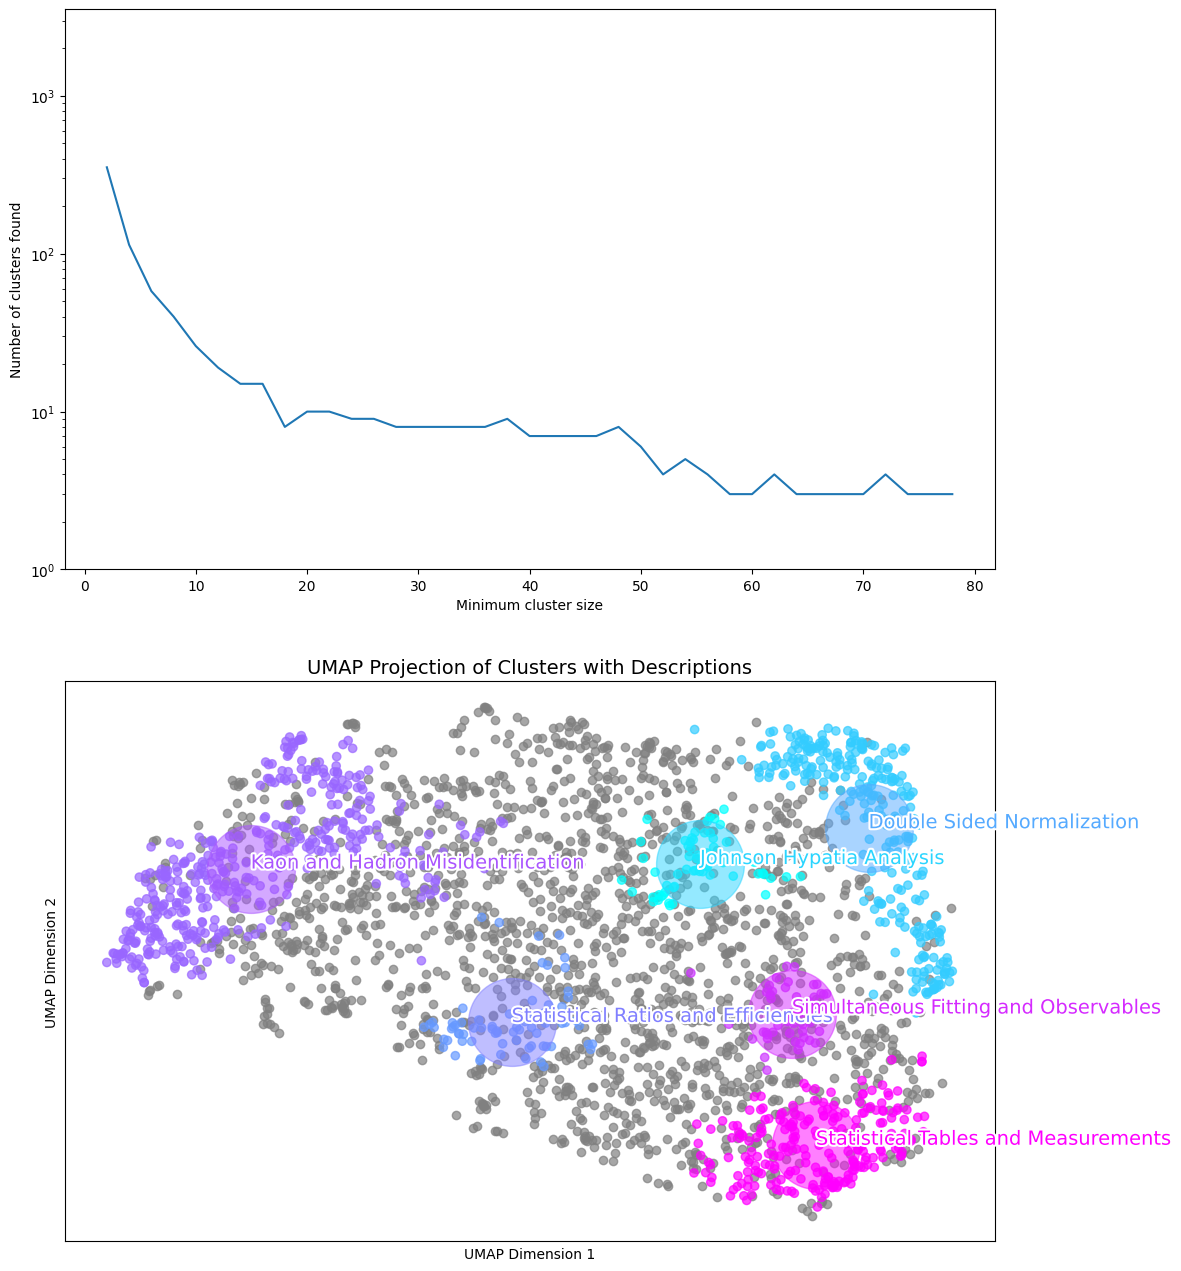

(array([-1, -1, -1, ..., -1,  0,  3]),
 {0: 'Johnson Hypatia Analysis',
  1: 'Double Sided Normalization',
  2: 'Statistical Ratios and Efficiencies',
  3: 'Kaon and Hadron Misidentification',
  4: 'Simultaneous Fitting and Observables',
  5: 'Statistical Tables and Measurements'},
 [['psi',
   'lhcb',
   'decay',
   'decays',
   'signal',
   'fit',
   '0_',
   'background',
   'uncertainty',
   'using',
   'systematic',
   'candidates',
   'paper',
   'lhcb paper',
   'used',
   'uncertainties',
   'efficiency',
   'detector',
   'sec',
   'phi',
   'chi',
   'simulation',
   'selection',
   'xi',
   'section',
   'p_t',
   'b_s',
   'model',
   'reconstructed',
   'branching',
   'state',
   'results',
   'candidate',
   'final',
   'parameters',
   'trigger',
   'vertex',
   '_c',
   'momentum',
   'particles',
   'distribution',
   'sample',
   'invariant',
   'measured',
   '_b',
   'determined',
   'gamma',
   'mev',
   'meson',
   'described',
   'yields',
   'combinatorial',
  

In [79]:
cluster_topics(subcluster_chunks, subcluster_embeddings, context=subcluster_label, ignore_keywords=subcluster_ignore_keywords, reduced_dim=16, min_cluster_size=40, keyword_cutoff=0.25)

### Filtering LHCb corpus to find discussions of analysis techniques
##### Data Curation (cuts and stuff) -> Data Augmentation () -> Making Figures

In [112]:
tex_dir = "/work/submit/mcgreivy/beauty-in-stats/src/scraper/data/cleaned_tex/1102.0206.tex"
with open(tex_dir) as f:
    text = f.read()

In [113]:
document = Document(text=text)

text_splitter = SentenceSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separator="\n",
    paragraph_separator="\n\n",
    secondary_chunking_regex="(?<=[.!?])\s+",
)

chunks = np.array([node.text for node in text_splitter.get_nodes_from_documents([document])])

In [116]:
chunks

array(['\\belowpdfbookmark{LHCb author list}{authors}\n\\section{Introduction}\nIn B_s^0 decays some final states can be reached either by a direct decay amplitude or via a mixing amplitude. For the case of B_s^0 {\\to} J/\\psi \\phi decays, the interference between these two amplitudes allows observation of a CP violating phase. In the Standard Model (SM) this phase is -2 \\beta_s=-0.036^{+0.0020}_{-0.0016} radians, where \\beta_s=\\arg (-V_{ts}V_{tb}^*/V_{cs}V_{cb}^* ), and the V_{ij} are CKM matrix elements \\cite{Charles}. This is about 20 times smaller in magnitude than the measured value of the corresponding phase 2 \\beta in B^0 mixing. Being small, this phase can be drastically increased by the presence of new particles beyond the SM. Thus, measuring \\beta_s is an important probe of new physics.\nAttempts to determine \\beta_s have been made by the CDF and D periments at the Tevatron using the B_s^0 {\\to} J/\\psi \\phi decay mode \\cite{Tevatron0}. While initial results hinte

In [117]:
print(text)

\belowpdfbookmark{LHCb author list}{authors}
\section{Introduction}
In B_s^0 decays some final states can be reached either by a direct decay amplitude or via a mixing amplitude. For the case of B_s^0 {\to} J/\psi \phi decays, the interference between these two amplitudes allows observation of a CP violating phase. In the Standard Model (SM) this phase is -2 \beta_s=-0.036^{+0.0020}_{-0.0016} radians, where \beta_s=\arg (-V_{ts}V_{tb}^*/V_{cs}V_{cb}^* ), and the V_{ij} are CKM matrix elements \cite{Charles}. This is about 20 times smaller in magnitude than the measured value of the corresponding phase 2 \beta in B^0 mixing. Being small, this phase can be drastically increased by the presence of new particles beyond the SM. Thus, measuring \beta_s is an important probe of new physics.
Attempts to determine \beta_s have been made by the CDF and D periments at the Tevatron using the B_s^0 {\to} J/\psi \phi decay mode \cite{Tevatron0}. While initial results hinted at possible large deviati